In [105]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [128]:
%reload_ext autoreload

In [129]:
import logging
import logging.config
import configparser
import os
import time
from pathlib import Path
import signal
from cachepath import CachePath, TempPath, Path
import requests
import shutil



import lmsquery
from waveshare_epd import epd5in83

In [130]:
import cfg
import epdlib

In [87]:
# this works best as a global variable
logConfig = Path(cfg.LOGCONFIG)
logging.config.fileConfig(logConfig.absolute())
# logging.basicConfig(level=logging.DEBUG, format='%(asctime)s %(name)s %(levelname)s: %(message)s')

logger = logging.getLogger(__name__)

In [101]:
logging.getLogger().setLevel(logging.DEBUG)

In [46]:
appShortName = 'slimpi'
name = 'com.txoof.'
appLongName = name+appShortName

In [47]:
def configuration(configFile=None):
    
    configDefaults = cfg.CONFIGDEFAULTS
    
    if not configFile:
         configFile = Path(cfg.CONFIGFILE)

    config = configparser.ConfigParser()
    logger.info(f'reading configuration: {configFile}')
    config.read(configFile)
    
    try:
        for section in configDefaults:
            if section not in config.sections():
                logger.debug(f'adding section: {section}')
                config.add_section(section)
            
            for option in configDefaults[section]:
                if not config.has_option(section, option):
                    logger.debug(f'missing option: {option}')
                    logger.debug(f'setting {option} to: {configDefaults[section][option]}')
                    config[section][option] = str(configDefaults[section][option])
            with open(configFile, 'w') as file:
                config.write(file)
    
    except Exception as e:
        logging.exception(f'exception on configuration file: {e}')
        raise
    
    logger.debug(f'config file contains sections: {config.sections()}')
    return config

In [48]:
def query(lms, last=0, delay=7):
    '''query the player only when a specified delay has passed
    Accepts:
        last: float - last time query was called

    Returns:
        tuple(last, lms.now_playing()
    '''
    if last==0:
        last = time.clock_gettime(time.CLOCK_MONOTONIC)-delay

    if time.clock_gettime(time.CLOCK_MONOTONIC) > last+delay:
        return time.clock_gettime(time.CLOCK_MONOTONIC), lms.now_playing()

    else:
        return last, None

In [49]:
def cacheArt(query={}):
    if not query:
        return None
    
    cachePath = CachePath(appLongName, dir=True)
    required = ['artwork_url', 'album_id'] 
    missing = []
    
    for key in required:
        if not key in query:
            missing.append(key)
    if missing:
        logger.warning(f'required value(s) in `query` missing: {missing}')
        return None
    
    albumArtFile = cachePath/(query['album_id']+'.jpg')
    
    # check if file already exists in cache
    if albumArtFile.exists():
        logging.debug(f'album artwork already downloaded at: {albumArtFile}')
        return albumArtFile
    
    r = False
    albumArtURL = query['artwork_url']
    
    # try to fetch the album art
    try:
        r = requests.get(albumArtURL, stream=True)
    except requests.exceptions.RequestException as e:
        logging.error(f'failed to fetch artwork at {albumArtURL}: {e}')
        
    if r:
        try:
            with open(albumArtFile, 'wb') as outFile:
                shutil.copyfileobj(r.raw, outFile)
                logging.debug(f'wrote album art to: {albumArtFile}')
        except (OSError, FileExistsError, ValueError) as e:
            logging.error(f'failed to write {albumArtFile}: {e}')
    else:
        logging.error('skipping download of album artwork due to previous errors')

    return albumArtFile
    

In [50]:
class signalHandler(object):
    '''handle specific signals and allow graceful exiting while loop
    https://stackoverflow.com/a/31464349/5530152
    
    Signals Handled Gracefully:
        SIGINT
        SIGTERM
    Atributes:
        kill_now (bool) default: False
    '''
    kill_now = False
    def __init__(self):
        signal.signal(signal.SIGINT, self.exit_gracefully)
        signal.signal(signal.SIGTERM, self.exit_gracefully)
    
    def exit_gracefully(self, signum, frame):
        self.kill_now = True

In [51]:
def main():
    '''main entry point
    '''   
    logger.setLevel(logging.DEBUG)
    logger.info('Starting program')
    config = configuration()
    # scan for lms server and use the first one (this may be a terrible idea for other people)
#     lmsServer = lmsquery.scanLMS()[0]
    
    # define LMS query object
#     lms = lmsquery.LMSQuery(lmsServer['host'], lmsServer['port'], config.get('server', 'player'))
    lms = lmsquery.LMSQuery(player_id=config.get('server', 'player'))
    
    screen = epdlib.Screen()
    screen.epd = epd5in83.EPD()
    screen.initEPD()
#     screen.clearEPD()
    layout = epdlib.Layout(layout=epdlib.layouts.threeRow)
    layout.update_contents(query(lms, 0)[1])
    screen.initEPD()
    screen.elements=layout.blocks.values()
#     screen.concat()
#     screen.writeEPD()    
    
    
    sigHandler = signalHandler()
    
    # last update
    updated = 0
    # id of currently playing track
    nowPlayingID = None
    # status of player 
    nowPlayingMode = None

    # now playing fields to display
    fields = ['title', 'album', 'artist', 'mode', 'artwork_url']
    
    
    print(f'pid: {os.getpid()}')
    try:
        while not sigHandler.kill_now:
            # add some try: around this
            updated, value = query(lms=lms, last=updated, delay=3)
            
            response = value
            
            # if there's a response, check to see if display needs an update
            if response: 
                # if the album ID changed the player state changed, update the display
                if response['id'] != nowPlayingID or response['mode'] != nowPlayingMode:
                    
                    albumArt = cacheArt(response)
                    
                    if not albumArt:
                        albumArt = cfg.NOIMAGE
                        
                    value['coverart'] = str(albumArt)
                    
                    layout.update_contents(value)
                    screen.initEPD()
                    screen.elements=layout.blocks.values()
                    screen.concat()
                    screen.writeEPD()                      
                    
                    nowPlayingID = response['id']
                    nowPlayingMode = response['mode']
                    for field in fields:
                        print(f'{field}: {response[field]}')
                    print('\n')
            time.sleep(0.5)
    finally:
        print("cleaning up")
        screen.initEPD()
        screen.clearEPD()
        return layout    

In [75]:
if __name__ == '__main__':
    
    foo = main()

Layout:__init__:92:INFO - create layout
Layout:_calculate_layout:222:INFO - ***title***
Layout:_calculate_layout:222:INFO - ***coverart***
Layout:_calculate_layout:222:INFO - ***artist***
Layout:_calculate_layout:222:INFO - ***album***
Layout:_calculate_layout:222:INFO - ***mode***
Block:__init__:221:INFO - create TextBlock
Block:__init__:142:INFO - create ImageBlock
Block:__init__:221:INFO - create TextBlock
Block:__init__:221:INFO - create TextBlock
Block:__init__:221:INFO - create TextBlock
pid: 707
title: Sinking
album: The Head on the Door
artist: The Cure
mode: play
artwork_url: http://192.168.178.9:9000/music/27ac4369/cover.jpg


title: Mountain Cry
album: Travelers & Thieves
artist: Blues Traveler
mode: play
artwork_url: http://192.168.178.9:9000/music/6793ecf0/cover.jpg


<ipython-input-49-8dcb301e2ede>:cacheArt:40:ERROR - skipping download of album artwork due to previous errors
Block:image:167:WARNING - could not open image at /tmp/com.txoof.slimpi/5563.jpg
Block:image:168:W

In [53]:
    sc = epdlib.Screen()
    sc.epd = epd5in83.EPD()
    sc.initEPD()
    sc.clearEPD()

True

In [131]:
tl = epdlib.Layout(layout=epdlib.layouts.clock)

Layout:__init__:92:INFO - create layout
Layout:layout:192:DEBUG - calculating values from layout for resolution (600, 448)
Layout:_calculate_layout:222:INFO - ***time***
Layout:_check_keys:109:DEBUG - checking key/values
Layout:_check_keys:114:DEBUG - missing key: dimensions; adding and setting to None
Layout:_calculate_layout:229:DEBUG - dimensions: (600, 392)
Layout:_calculate_layout:258:DEBUG - has explict position
Layout:_calculate_layout:260:DEBUG - abs_coordinates: (0, 0)
Layout:_scalefont:135:DEBUG - calculating font size
Layout:_scalefont:136:DEBUG - using font at path: /home/pi/src/slimpi_epd/fonts/Ubuntu/Ubuntu-Regular.ttf
Layout:_scalefont:148:DEBUG - target X font dimension 510.0
Layout:_scalefont:149:DEBUG - target Y dimension: 274.4
Layout:_scalefont:162:DEBUG - X target exceeded
Layout:_scalefont:178:DEBUG - test string: W W W ; dimensions for fontsize 146: (513, 137)
Layout:_calculate_layout:222:INFO - ***mode***
Layout:_check_keys:109:DEBUG - checking key/values
Layout

In [110]:
from PIL import Image

In [132]:
i = Image.new('1', (600, 7), color=0)

In [147]:
upd = {'time': '20:40', 'mode': 'stopped', 'bar': i}
tl.update_contents(upd)

Layout:update_contents:312:DEBUG - updating blocks
Layout:update_contents:318:DEBUG - updating block: time
Block:text_formatter:324:DEBUG - formatted list:
 ['20:40']
Block:_text2image:341:DEBUG - random is set: True
Block:_text2image:354:DEBUG - text image dimensions: (364, 139)
Block:_text2image:375:DEBUG - setting random position within area
Layout:update_contents:318:DEBUG - updating block: mode
Block:text_formatter:324:DEBUG - formatted list:
 ['stopped']
Block:_text2image:341:DEBUG - random is set: True
Block:_text2image:354:DEBUG - text image dimensions: (134, 41)
Block:_text2image:375:DEBUG - setting random position within area
Layout:update_contents:318:DEBUG - updating block: bar
Block:image:160:DEBUG - formatting image: <PIL.Image.Image image mode=1 size=600x7 at 0xAFE745F0>
Block:image:162:DEBUG - set image dimensions: 7
Block:image:173:DEBUG - using passed image
Block:image:176:DEBUG - resizing image
Block:image:193:DEBUG - set img_coordinates: (0, 441)


In [148]:
sc.elements = tl.blocks.values()

Screen:concat:88:DEBUG - pasting image at: (0, 0)
Screen:concat:88:DEBUG - pasting image at: (0, 392)
Screen:concat:88:DEBUG - pasting image at: (0, 441)


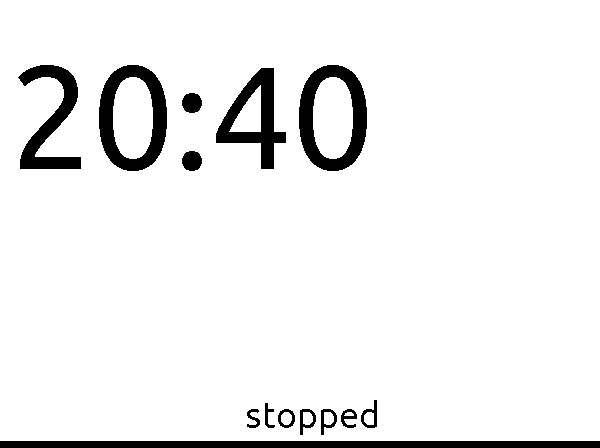

In [149]:
sc.concat()

In [150]:
sc.initEPD()
sc.writeEPD()

epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
epd5in83:getbuffer:128:DEBUG - imwidth = 600  imheight =  448 
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
epd5in83:ReadBusy:69:DEBUG - e-Paper busy
epd5in83:ReadBusy:72:DEBUG - e-Paper busy release
epdconfig:module_exit:80:DEBUG - spi end
epdconfig:module_exit:83:DEBUG - close 5V, Module enters 0 power consumption ...


True

In [97]:
import datetime

In [63]:
l = epdlib.Layout(resolution=(600, 392))

Layout:__init__:92:INFO - create layout
Layout:layout:194:INFO - no layout provided


In [64]:
l._scalefont(font='./fonts/Ubuntu/Ubuntu-Regular.ttf', dimensions=(600,392))

146

In [65]:
b = epdlib.Block.TextBlock(font='./fonts/Ubuntu/Ubuntu-Regular.ttf', font_size=87, area=(600, 392))

Block:__init__:221:INFO - create TextBlock


In [66]:
help(b)

Help on TextBlock in module epdlib.Block object:

class TextBlock(Block)
 |  TextBlock(text=' ', font=None, font_size=24, max_lines=1, maxchar=None, chardist=None, *args, **kwargs)
 |  
 |  Method resolution order:
 |      TextBlock
 |      Block
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, text=' ', font=None, font_size=24, max_lines=1, maxchar=None, chardist=None, *args, **kwargs)
 |      Constructor for ImageBlock Class.
 |      
 |      Args:
 |          image (PIL.Image): Image to be formatted and resized to fit within
 |              area
 |          area (:obj:`tuple` of :obj: `int`): x, y integer dimensions of 
 |              maximum area in pixles
 |          abs_coordinates (:obj:`tuple` of `int`): x, y integer coordinates of image area
 |              within a larger image
 |          hcenter (boolean, optional): True - horizontal-align image within the area, 
 |              False - left-align image
 |          vcenter (boolean, optional):

In [67]:
t = datetime.datetime.now().time()
timeStr = f'{t.hour}:{t.minute}'